# Encapsulating custom code into Gym environments: A turning controller

**Summary:** In this tutorial, we will demonstrate how one can build controllers at different levels of abstraction by implementing Gym environments encoding variable amounts of preprogrammed computation. As an example, we will implement turning by asymmetrically modulating the amplitude and frequency of CPGs.

## Gym environments and MDP

So far, we have interacted with the `NeuroMechFly` class which implements the [Gym interface](https://gymnasium.farama.org/): it has an action space (input given by the user), an observation space (output returned to the user), a `.step(...)` method, a `.reset(...)` method, and a `.render(...)` method. The action and observation spaces of `NeuroMechFly` are as follows:

- Action space:
    - "joints": 42-dimensional real vector ∈ [0, 2π] indicating joint angles (in default position control mode)
    - "adhesion": 6-dimensional integer vector ∈ {0, 1} indicating whether adhesion is turned on for each leg
- Observation space:
    - "joints": shape (3, 42) real array indicating joint angles (0th row), velocities (1st row), and torques (2nd row)
    - "fly": shape (4, 3) real array indicating fly xyz positions (0th row), xyz velocities (1st row), yaw-pitch-roll angles (2nd row), and yaw-pitch-roll velocities (3rd row)
    - "contact_forces": shape (N, 3) - contact forces, in xyz directions, of the N segments defined in `contact_sensor_placements`
    - "end_effectors": shape (6, 3) - xyz positions of the six legs in the order of LF, LM LH, RF, RM, RH
    - "fly_orientation": shape (3,) - unit vector indicating the fly's heading orientation


The FlyGym package is designed to be expandable: the user can implement their own Gym environments with different action and observation spaces and implement different logics (e.g. preprogrammed premotor computation and sensory processing). This is illustrated in the figure below:

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/mdp.png?raw=true" alt="rule_based" width="500"/>

In the CPG controller that [we have implemented](https://github.com/NeLy-EPFL/cobar-exercises-internal/blob/main/week2/1_cpg_controller.ipynb), the underlying CPG network and the correction mechanisms can be considered the user-defined premotor computation (purple). The whole controller can be considered the box indicating the Markov Decision Process (MDP). Here, we will add a 2D descending signal that encodes turning. The action and observation spaces of our MDP "box" are as follows:

- Action space: a 2-dimensional real vector describing the velocity on each side of the body. Although in principle the range of the amplitude is unrestricted, its absolute value shouldn't go far beyond 1 because otherwise the steps become very unrealistic.
- Observation space: same as above (no sensory processing logic indicated in cyan)

## Approach for turning

We will use a 2-dimensional representation of descending signals $[\delta_L, \delta_R] \in \mathbb{R}^2$ to modulate the amplitude and direction of the leg CPGs on each side of the body. Specifically, we will modulate the intrinsic amplitude $R'$ and intrinsic frequency $\nu'$ on each side by:

$$
R'(\delta) = |\delta|
$$

$$
\nu_i'(\delta) = \begin{cases}
\nu_i   & \text{if } \delta>0\\
-\nu_i  & \text{otherwise}
\end{cases}
$$

In other words, the magnitude of the descending signal controls the amplitude of stepping (as a gain applied to the originally recorded step size); the sign of the descending signal controls the direction of stepping. Of course, this is a very simplified model of turning. Perhaps the most unrealistic aspect of it is that it assumes that the step size spans linearly from 0 to 1x the recorded "real" step size. This is an area for future improvement.

## Implementing the `TurningController` class

A key idea of the Gym interface is that it allows users to encapsulate the control logic in a Gym environment (a MDP), and expose only the input and output (action and observation) to the controller. This is achieved using [class inheritance](https://www.w3schools.com/python/python_inheritance.asp) in Python. Briefly, it allows a new class (subclass or child class) to inherit attributes and methods from an existing class (base class or parent class), enabling code reuse and the creation of hierarchical relationships between classes. Refer to the tutorial linked above to familiarize yourself with this concept.

All Gym environments inherit from the `gymnasium.Env` class. You can refer to [the API reference of this class](https://gymnasium.farama.org/api/env/#gymnasium-env) for a full specification, or [this page](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/) for a tutorial on how to make your own custom environment. The `NeuroMechFly` class we have used so far inherits from it and therefore complies with its specifications. Here, we will build a `TurningController` class that inherits from `NeuroMechFly` to provide a simplified interface to control turning via a 2D input space, which can be interpreted as a descending code.

First, let's do the necessary imports and define the default parameter as before:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from gymnasium import spaces
from gymnasium.utils.env_checker import check_env

from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.cpg_controller import CPGNetwork


_tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
_tripod_coupling_weights = (_tripod_phase_biases > 0) * 10

Now, we will define the `__init__` method of our `TurningNMF` class.

We start with initializing the parent class by calling `super().__init__(...)`. This basically calls the `__init__` logic of the parent `NeuroMechFly` class using the specified parameters:

```python
class TurningNMF(NeuroMechFly):
    def __init__(
        self,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        amplitude_range=(-0.5, 1.5),
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        super().__init__(**kwargs)

        ...
```

We can save the arguments as class attributes:

```python
        ...
        
        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.amplitude_range = amplitude_range

        ...
```

Next, we need to override the action space of `NeuroMechFly`. This is done by defining a new Gym space object. Gym provides an [interface for various space types](https://gymnasium.farama.org/api/spaces/). An non-exhaustive list includes `Box` for a possibly-bounded box in $\mathbb{R}^n$, `Discrete` for a finite set of options, `Text` for text, and various [composite spaces](https://gymnasium.farama.org/api/spaces/composite/) such as `Dict`, `Tuple`, `Sequence`, `Graph`. Here, we will define the descending space as a `Box` space. We won't change the observation space definition since we will return `NeuroMechFly`'s observation as is:

```python
        ...

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        ...
```

Then, we will initialize the CPG network that we defined [in the CPG tutorial](https://neuromechfly.org/tutorials/cpg_controller.html):

```python
        ...
        
        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)

        ...
```

Next, we shall define the `reset` method of our `TurningController` class. This involves resetting the underlying `NeuroMechFly` simulation — as before, we will call `super().reset(...)` to drop in the reset method of the parent class. Then, we will reset the CPG network. Note that the `**kwargs` argument is required to fully comply with the Gym API. In general, this gives the user more flexibility to pass additional arguments when initializing the Gym environment.

```Python
    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.reset(init_phases, init_magnitudes)
        return obs, info
```

Now, we are ready to implement the most important `step` method. We start by updating the intrinsic amplitudes and frequencies of the CPGs as formulated above:

```Python
    def step(self, action):
        """Step the simulation forward one timestep.
        
        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).ravel()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs
```

Next, we can step the CPG:

```Python
        ...
        
        self.cpg_network.step()

        ...
```

Then, we write a loop to go through each of the legs. In this loop, we calculate the target joint angles using the preprogrammed step class and decide whether adhesion should be turned off for swinging:

```python
        ...
        
        joints_angles = []
        adhesion_onoff = []
        for i, leg in enumerate(self.preprogrammed_steps.legs):
            # get target angles from CPGs and apply correction
            my_joints_angles = self.preprogrammed_steps.get_joint_angles(
                leg,
                self.cpg_network.curr_phases[i],
                self.cpg_network.curr_magnitudes[i],
            )
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = self.preprogrammed_steps.get_adhesion_onoff(
                leg, self.cpg_network.curr_phases[i]
            )
            adhesion_onoff.append(my_adhesion_onoff)

        ...
```

Finally, we build the action dictionary (recall from our discussion on Gym spaces above — this is a composite `Dict` space) and call the `step` method of the parent `NeuroMechFly` class using it. This concludes the definition of our `step` method.

```Python
        ...
        
        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)
```

Let's put the code together:

In [3]:
class TurningNMF(NeuroMechFly):
    def __init__(
        self,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        amplitude_range=(-0.5, 1.5),
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        super().__init__(**kwargs)

        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.amplitude_range = amplitude_range

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)

    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.intrinsic_amps = self.intrinsic_amps
        self.cpg_network.intrinsic_freqs = self.intrinsic_freqs
        self.cpg_network.reset(init_phases, init_magnitudes)
        return obs, info

    def step(self, action):
        """Step the simulation forward one timestep.

        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).flatten()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs

        self.cpg_network.step()

        joints_angles = []
        adhesion_onoff = []
        for i, leg in enumerate(self.preprogrammed_steps.legs):
            # get target angles from CPGs and apply correction
            my_joints_angles = self.preprogrammed_steps.get_joint_angles(
                leg,
                self.cpg_network.curr_phases[i],
                self.cpg_network.curr_magnitudes[i],
            )
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = self.preprogrammed_steps.get_adhesion_onoff(
                leg, self.cpg_network.curr_phases[i]
            )
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)

In [4]:
run_time = 1
timestep = 1e-4
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_top",
    render_playspeed=0.1,
    enable_adhesion=True,
    draw_adhesion=True,
)

nmf = TurningNMF(
    sim_params=sim_params,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0, 0, 0.2),
)

We can use Gymnasium's `env_checker` utility to check if our `TurningNMF` class fully complies with the Gym API. To do this, `env_checker` will reset our environment a few times with random parameters and step it with random actions. It will then check if the observations are as specified in the observation space definition. If no exception is raised, we are in good shape.

In [5]:
check_env(nmf)

c:\Users\mulle\miniconda3\envs\flygym\Lib\site-packages\gymnasium\utils\env_checker.py:247: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(
c:\Users\mulle\miniconda3\envs\flygym\Lib\site-packages\gymnasium\utils\env_checker.py:225: UserWarning: WARN: A Box observation space minimum value is -infinity. This is probably too low.
  logger.warn(
c:\Users\mulle\miniconda3\envs\flygym\Lib\site-packages\gymnasium\utils\env_checker.py:229: UserWarning: WARN: A Box observation space maximum value is -infinity. This is probably too high.
  logger.warn(
c:\Users\mulle\miniconda3\envs\flygym\Lib\site-packages\gymnasium\utils\env_checker.py:321: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantialising the environment through gymnasium.make
  logger.warn

Let's run the simulation, applying a steady [1.2, 0.2] turn throughout. We will also record the magnitude of the CPGs over time.

In [6]:
magnitude_hist = []
obs, info = nmf.reset(seed=0)
for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i * nmf.sim_params.timestep
    action = np.array([1.2, 0.2])
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:28<00:00, 346.20it/s]


Let's visualize the time series of the CPG magnitudes. As expected, three CPGs converge to a faster step while the others converge to a smaller one.

Un sous-r�pertoire ou un fichier -p existe d�j�.
Une erreur s'est produite lors du traitement de�: -p.
Un sous-r�pertoire ou un fichier outputs existe d�j�.
Une erreur s'est produite lors du traitement de�: outputs.


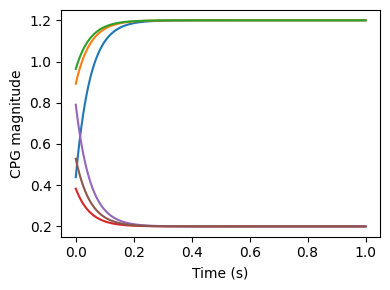

In [7]:
!mkdir -p outputs
t = np.arange(0, run_time, nmf.sim_params.timestep)
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
for ts in np.array(magnitude_hist).T:
    ax.plot(t, ts)
ax.set_xlabel("Time (s)")
ax.set_ylabel("CPG magnitude")
fig.savefig("./outputs/turning_cpg_magnitude.png")

Finally, let's take a look at the video:

In [8]:
from IPython.display import Video

nmf.save_video("./outputs/turning.mp4")
Video("./outputs/turning.mp4")

# Exercise 1
In this exercise, let's quantify how much the fly turns over time with a descending signal of [0.2, 1.2].

In [9]:
run_time = 6
obs, info = nmf.reset(seed=0)
obs_hist = []

for i in trange(int(run_time / nmf.sim_params.timestep)):
    action = np.array([0.2, 1.2])
    obs = nmf.step(action)[0]
    obs_hist.append(obs)
    nmf.render()

nmf.save_video("./outputs/turning_6s.mp4")
Video("./outputs/turning_6s.mp4")

  0%|          | 0/60000 [00:00<?, ?it/s]

100%|██████████| 60000/60000 [02:52<00:00, 347.89it/s]


Compute the change in the heading angle over time:

Text(0, 0.5, 'Heading angle change (rad)')

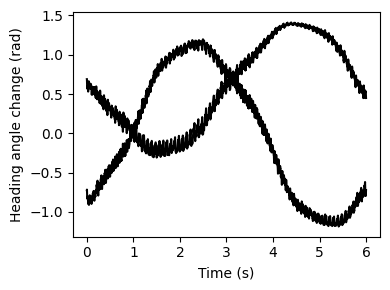

In [57]:
#################################################################################
# TODO: Calculate the change in heading angle over time (~3 lines of code)
# Hint 1: Which element of the observation dictionary contains the heading angle?
# Hint 2: Use numpy.unwrap to handle the 2pi wrap-around:
# https://numpy.org/doc/stable/reference/generated/numpy.unwrap.html

heading_angle_change = np.diff(np.unwrap([obs["fly_orientation"] for obs in obs_hist]))
#################################################################################

fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
t = np.arange(0, run_time, nmf.sim_params.timestep)
ax.plot(t, heading_angle_change, c="k")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Heading angle change (rad)")

It looks like the amount of turning is linearly correlated to the elapsed time. Let's define a function to calculate the slope of the line.

-0.21780854095133687
Turning speed = -0.21780854095133687 rad/s


Text(0, 0.5, 'Heading angle change (rad)')

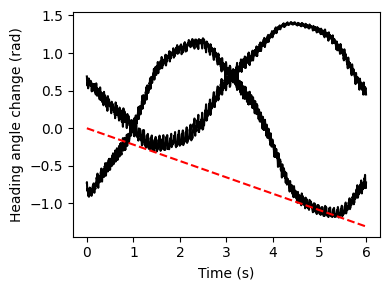

In [58]:
import statistics

def get_slope(x, y):
    ################################################################################
    # TODO: Calculate the slope of the line
    # Hint: Instead of implementing linear regression yourself, you can
    # existing implementations, such as the linear_regression function from
    # the statistics module in the Python standard library:
    # https://docs.python.org/3/library/statistics.html#statistics.linear_regression
    y_prime = []
    for i in range(len(y)):
        y_prime.append(y[i][0])
    slope = statistics.linear_regression(x, y_prime)[0]
    print(slope)
    ################################################################################

    return slope


turning_speed = get_slope(t, heading_angle_change)
print(f"Turning speed = {turning_speed} rad/s")

fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
t = np.arange(0, run_time, nmf.sim_params.timestep)
ax.plot(t, heading_angle_change, c="k")
ax.plot(t, turning_speed * t, ls="--", c="r")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Heading angle change (rad)")

# Exercise 2:
In theory, we have the capability to modulate the fly's turning using a scalar signal rather than a 2D descending signal.

Let's create a class whose action space is $[-1, 1]\in\mathbb{R}$. In this space, the signals -1, 0, and 1 correspond to turning left, walking forward, and turning right, respectively. We can achieve this by extending the functionality of the existing `TurningNMF` class and incorporating the conversion from a 1D to a 2D descending signal inside the `step` method. The conversion process is illustrated in the diagram below:

![](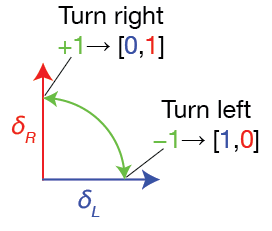
)

In [ ]:
class TurningNMF1D(TurningNMF):
    def __init__(self, r=1, **kwargs):
        super().__init__(**kwargs)

        ############################################################################
        # TODO: Define the action space using spaces.Box (1 line of code)
        # Refer to https://www.gymlibrary.dev/api/spaces/#gym.spaces.Box for details

        self.action_space = ...
        ############################################################################

    def step(self, action):
        ############################################################################
        # TODO: Convert the 1D action to 2D action  (~2 lines of code)

        action = ...
        ############################################################################
        return super().step(action)


nmf1d = TurningNMF1D(
    sim_params=sim_params,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0, 0, 0.2),
)

check_env(nmf1d)

Let's use a triangle wave as the action:

In [ ]:
from scipy.signal import sawtooth

run_time = 4
n_steps = int(run_time / nmf.sim_params.timestep)
actions = sawtooth(np.linspace(0, 4 * np.pi, n_steps), 0.5)

fig, ax = plt.subplots(1, 1, figsize=(4, 2), tight_layout=True)
ax.plot(np.arange(n_steps) * nmf.sim_params.timestep, actions, c="k")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Action")

In [ ]:
obs_hist = []
obs, info = nmf1d.reset(seed=0)

for i in trange(n_steps):
    obs = nmf1d.step(actions[i])[0]
    obs_hist.append(obs)
    nmf1d.render()

nmf1d.save_video("./outputs/turning1d.mp4")
Video("./outputs/turning1d.mp4")

Plot the trajectory of the fly:

In [ ]:
#################################################################
# TODO: get the fly's trajectory from obs_hist
trajectory = ...
#################################################################

fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(trajectory[:, 0], trajectory[:, 1], color="k")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

What limitation does the `TurningNMF1D` class have compared to the `TurningNMF` class?

TODO: Your answer here